In [1]:
import numpy as np
from scipy.stats import norm

print("What is the price of the stock?")
stock = int(input())
print("What is the Strike price?")
strike = int(input())
print("what is the volatility(standard deviation)? Enter whole number")
sd = float(input())/100
print("What is the interest rate? Enter whole number")
ir = float(input())/100
print("What is the duration of the contract?(in years)")
years = int(input())


def black_scholes_put(S, X, sigma, r, t):
    d1 = (np.log(S/X) + (r + ((sigma**2)/2))*t) / (sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    P = (X * np.exp(-r*t) * norm.cdf(-d2)) - (S * norm.cdf(-d1))
    return P
black_scholes_put(stock, strike, sd, ir, years)

What is the price of the stock?


 100


What is the Strike price?


 100


what is the volatility(standard deviation)? Enter whole number


 30


What is the interest rate? Enter whole number


 5


What is the duration of the contract?(in years)


 1


np.float64(9.354197236057232)

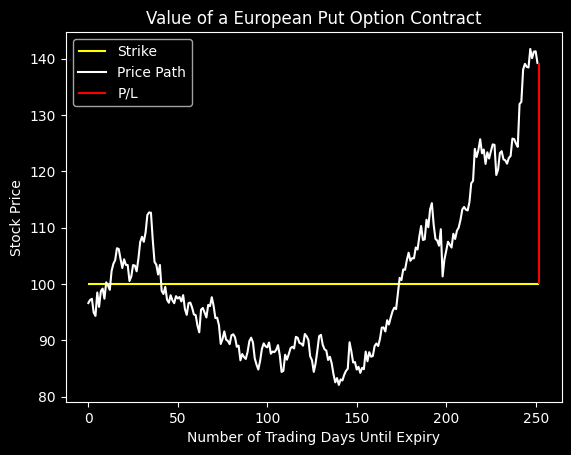

Premium at t=0: 9.354197236057232
P/L: -9.354197236057232


In [3]:
import matplotlib.pyplot as plt
import qfin as qf

mu = ir
dt = years/(252 * years)

path = qf.simulations.GeometricBrownianMotion(stock, mu, sd, dt, years)

plt.title("Value of a European Put Option Contract")
plt.hlines(strike, 0, 252*years, label='Strike', color='yellow')
plt.plot(path.simulated_path, label='Price Path', color='white')
if max(strike - path.simulated_path[-1], 0) == 0:
    plt.vlines(252*years, path.simulated_path[-1], strike, color='red', label="P/L")
else:
    plt.vlines(252*years, strike, path.simulated_path[-1], color='green', label="P/L")
plt.style.use('dark_background')
plt.xlabel('Number of Trading Days Until Expiry')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print("Premium at t=0:", black_scholes_put(stock, strike, sd, ir, years))
print("P/L:", max(strike - path.simulated_path[-1], 0) - black_scholes_put(stock, strike, sd, ir, years))

In [4]:
print("Put Price:", black_scholes_put(stock, strike, sd, ir, years))
print("What is the Market Price of a Put Option Contract?")
marketprice = float(input())
print("Price discrepancy:", black_scholes_put(stock, strike, sd, ir, years) - marketprice)

Put Price: 9.354197236057232
What is the Market Price of a Put Option Contract?


 9.15


Price discrepancy: 0.20419723605723128


What is the number of shares do you want to trade?


 100


How many times would you like to repeat this trade?


 100


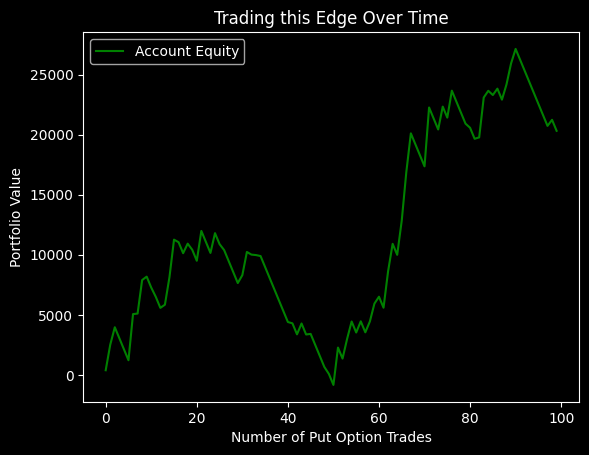

The value per option trade is $ 203.15
The total value of this trade is $ 20314.99


In [5]:
print("What is the number of shares do you want to trade?")
shares = int(input())
print("How many times would you like to repeat this trade?")
rep = int(input())

premium = marketprice * shares
pnl = []

for i in range(rep):
    path = qf.simulations.GeometricBrownianMotion(stock, mu, sd, dt, years)
    pnl.append(max(strike - path.simulated_path[-1], 0) * shares - premium)

plt.title("Trading this Edge Over Time")
if np.sum(pnl) <= 0:
    plt.plot(np.cumsum(pnl), label="Account Equity", color="red")
else:
    plt.plot(np.cumsum(pnl), label="Account Equity", color="green")
plt.style.use('dark_background')
plt.ylabel("Portfolio Value")
plt.xlabel("Number of Put Option Trades")
plt.legend()
plt.show()

mean = np.mean(pnl)
total = np.sum(pnl)
print("The value per option trade is $", round(mean, 2))
print("The total value of this trade is $", round(total, 2))



In [6]:
option_prices = np.linspace(start = marketprice - 2.5, stop = marketprice + 2.5, num = 10)  
volatilities = np.linspace(start = sd - .1, stop = sd + .1, num = 10)  

put_matrix = np.zeros((len(option_prices), len(volatilities)))

for i in range(rep):
    for v, vol in enumerate(volatilities):
        for o, premium in enumerate(option_prices):
            new_path = qf.simulations.GeometricBrownianMotion(stock, mu, vol, dt, years)
            newprofit = round(max(strike - new_path.simulated_path[-1], 0) - premium, 2)
            put_matrix[v,o] += newprofit    

print(put_matrix)

[[  -7.25  -99.39 -245.41 -380.4  -410.68 -322.95 -335.42 -477.64 -381.71
  -573.18]
 [  77.17  -26.49  -19.25 -210.79 -167.07 -133.15 -507.24 -110.25 -279.02
  -556.58]
 [  97.61   76.16   57.69  -51.1   168.01 -209.32 -335.94 -239.38 -408.8
  -339.41]
 [ 217.05   57.85  113.13  -19.34  -51.66  -33.65 -227.25 -221.9  -379.54
  -188.65]
 [ 432.82  129.34  275.1   168.64  -14.67   14.18  120.33  -78.27  -38.32
  -441.04]
 [ 315.77  200.59  448.11  -84.42  -21.33  100.17  198.85  -78.24  137.67
  -225.47]
 [ 459.95  382.82  289.3   208.37   26.42  152.14  156.87 -107.94 -166.32
  -173.06]
 [ 594.31  504.5    47.18  235.52  490.36  437.58  134.84  -10.3    58.8
   -70.56]
 [ 510.7   410.62  682.56  101.3   486.39  242.69  325.56   19.36 -244.64
    86.  ]
 [ 748.08  481.    735.02  427.36  637.16  199.87  466.78  723.73  121.27
   231.2 ]]


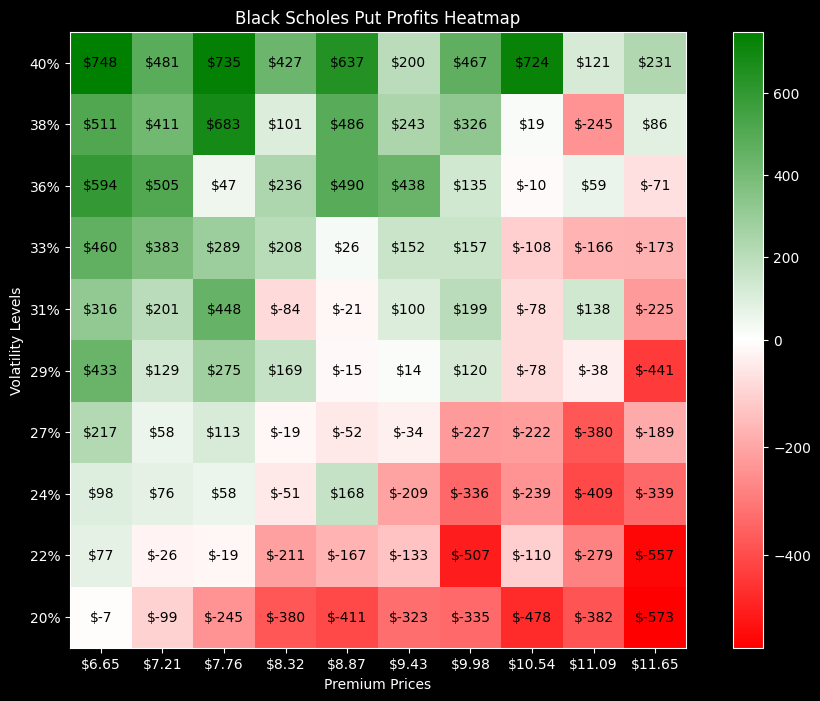

In [8]:
from matplotlib.colors import LinearSegmentedColormap as lsc
from matplotlib.colors import TwoSlopeNorm as tsn

colors = ["red", "white", "green"]
cmap = lsc.from_list("loss_win", colors)

vmin = put_matrix.min()
vmax = put_matrix.max()
norm = tsn(vcenter = 0, vmin = put_matrix.min(), vmax = put_matrix.max())

fig, ax = plt.subplots(figsize = (12, 8))
cax = ax.matshow(put_matrix, cmap=cmap, norm=norm)
fig.colorbar(cax)

for v in range(len(volatilities)):
    for o in range(len(option_prices)):
        text = ax.text(o, v, f"${round(put_matrix[v, o])}",
                    ha="center", va="center", color="black")

ax.set_xticks(range(len(option_prices)))
ax.set_yticks(range(len(volatilities)))

ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(len(option_prices)))
ax.set_xticklabels([f"${option:.2f}" for option in option_prices])

ax.set_yticks(np.arange(len(volatilities)))
ax.set_yticklabels([f"{vol*100:.0f}%" for vol in volatilities])

ax.invert_yaxis()

ax.set_xlabel('Premium Prices')
ax.set_ylabel('Volatility Levels')
ax.set_title('Black Scholes Put Profits Heatmap')

plt.show()